# COMPRESSÃO DE IMAGENS
### Trabalho 1 da Disciplina Introdução à Computação Visual
#### Aluno: Jorge Augusto de Lima e Silva

Professor: Willian Robson Schwartz

Universidade Federal de Minas Gerais - 2022/2

A proposta do trabalho foi desenvolver um compressor de imagens digitais. O método usado para a resolução do problema combina a compressão JPEG, realizando o descarte de frequências altas da imagem, pouco discernidas pelo olho humano, juntamente com a codificação de Huffman, buscando reduzir ao máximo a redundância de codificação dos dados após o processamento.

O notebook pode ser dividido em duas partes, a primeira na qual tem a declaração das funções, explicação de como essas funcionam , decisões de projeto e uma discussão sobre os resultados encontrados; e a segunda parte, na qual é feito um passo a passo do processo de compressão e descompressão, sendo possível observar os resultados intermediários.

# PARTE 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import fftpack
import pickle
import os

## 1) Funções Auxiliares
Funções de menor importância no código, que buscam, pricipalmente, tornar as funções princpais mais legíveis.

Algumas das funções foram retiradas do notebook que trata da compressão JPEG.

In [2]:
# Calcula a tranformada discreta do cosseno de uma matriz.
def get_2d_dct(img):
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

# Calcula a tranformada inversa do cosseno de uma matriz.
def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

# Calcula o erro médio quadrádico de duas imagens.
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calcula o sinal de pico para relação de ruído.
def PSNR(predictions, targets):
    rmsev = RMSE(predictions, targets)
    return 20 * np.log10(255/rmsev)

# Calcula a entropia de uma imagem.
def CalcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

# Calcula a quantidade de vezes que um mesmo valor aparece em uma lista.
def CalcHist(list):
    
    dictionary = {}

    for i in list:
        if dictionary.get(i) == None:
            dictionary[i] = 1
        else:
            dictionary[i] = dictionary[i]+1
            
    return dictionary

# Calcula a entropia a partir de um dicionário contendo a quantidade de vezes que cada chave aparece
def CalcEntropyDictionary(dictionary):
    total = sum(dictionary.values())
    probabilities = map(lambda x: x/total, dictionary.values())
    return sum(list(map(lambda x: -(x*np.log2(x)), probabilities)))

# Recebe um dicionário contendo os valores resultantes de uma codificação de Huffman e transforma a string binária 
# em um valor inteiro, permitindo que este seja armazenado em menos espaço no disco.
# A codificações feita transforma a string binária que representa o novo código em uma 2-tupla, na qual seu primeiro valor
# representa a quantidade de bits que a string tem e seu segundo valor o número em inteiro que a string representa.
def CompressDict(dictionary):
    new_dictionary = dict()
    
    for key in dictionary.keys():
        binary_value = dictionary[key]
        new_dictionary[key] = (len(binary_value), int(binary_value, 2))
        
    return new_dictionary

# Recebe um dicionário que foi comprimido na função anterior e volta-o para seu estado original, para que possa ser usado na
# descompressão da imagem.
def DecompressDict(dictionary):
    decomp_dict = dict()
    
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    
    for key in dictionary.keys():
        int_representation = dictionary[key]
        decomp_dict[key] = get_bin(int_representation[1], int_representation[0])
        
    return decomp_dict

# Transforma uma string binária em uma string de caracteres.
def bin2string(bin_string):
    bin2char = lambda x : chr(int(x,2))
    
    aux = bin_string
    
    # Adiciona zeros ao final da string para que o último grupo de  bits possa ser convertido em um caracter, uma vez que um
    # carcactere ascii tem o tamanho de um byte, ou seja, oito bits.
    if(len(bin_string)%8):
        for i in range(8-(len(bin_string)%8)):
            aux += '0'
    
    char_string = ''
    
    # Percorre a string de 8 em 8 bits, convertendo esses 8 bits do alfabeto {0,1} para o alfabeto ascii.
    for i in range(0, len(aux), 8):
        char_string += bin2char(bin_string[i:i+8])
    
    # Retorna a string codificada como caracteres.
    return char_string

# Recebe uma string codificada no alfabeto ascii e converte seus valores para os bits correspondentes.
def string2bin(char_string):
    char2bin = lambda x : format(ord(x), 'b').zfill(8)
    
    aux = ''
    
    for i in char_string:
        aux += char2bin(i)
        
    return aux

# Sabendo que a codificação de Huffman resulta em um mapeamento de 1 para 1 dos valores e códigos, para proposito de decodifica-
# ção, é mais eficiente inverter as chaves e valores mapeados a essas, sendo esse o objetivo dessa função.
def ReverseEncode(codes):
    reverseCodes = dict()
    
    for key in codes.keys():
        reverseCodes[codes[key]] = key
        
    return reverseCodes

## 2) Matriz de Quantização
Matriz de quantização usada para descartar coeficientes relacionados a frequências altas (ruído) após aplicar a tranformada discreta do cosseno em uma matriz.

A matriz foi retirada do notebook que trata da compressão JPEG, sendo a escolha dessa feita tendo em vista que ela equilibra o quanto de informação da imagem é perdida e quanta é mantida, de modo que uma quantidade considerável de coeficientes são descartadas sem que a qualidade da imagem seja consideravelmente afetada, aproveitando assim da redundância psico-visual existente na imagem.

In [3]:
# aplicação da tabela de quantização
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# quantization matrix
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QM = QM.astype(float)

## 3) Codificação de Huffman
A codificação de Huffman é um método que explora a redundância de codificação de um conjunto de dados como forma de comprimí-los. Com esse método, é gerada uma árvore, na qual as folhas mais próximais da raíz ocorrem com uma frequência maior dentre os dados do que as folhas que se encontram mais distantes. Portanto, a ideia do algoritmo é representar valores mais frequentes com menos bits do que originalmente são representados. O caminhamento pela árvore é capaz de fazer isso, gerando códigos livres de prefixos para todos as folhas. Trocando de contexto a Lei de Amdahl, temos que reduzindo o tamanho da string que representa um valor muito frequente, podemos diminuir de forma considerável o tamanho do código, uma vez que o impacto dessa redução é multiplicada pela quantidade de vezes que ele aparece nos dados.

Desta forma, levando em consideração a ideia do algortimo para a codificação de Huffman, é necessária uma estrutura de dados principal para a geração dos códigos, a Árvore Binária, a qual é implementada a seguir.

Tendo então a árvore, é necessária a criação de uma função que permite caminhar sobre essa para gerar os códigos. E, por fim, com os códigos gerados, tudo que falta é converter os dados em uma string binária contendo os valores após serem codificados.

In [4]:
# Classe que tem a função de representar uma árvore de Huffman, para a realização da codificação.
class Nodes:  
    def __init__(self, probability, symbol, left = None, right = None):  
        # A quantidade de vezes que o símbolo aparece nos dados. 
        self.probability = probability  
  
        # O símbolo em si.
        self.symbol = symbol  
  
        # O nó filho à esquerda.
        self.left = left  
  
        # O nó filho a direita.
        self.right = right  
  
        # O código parcial do nó, sendo 0 se esse for filho esquerdo do anterior e 1 se for filho direito.
        self.code = ''
        
# Função que calculo o código completo dos nós folhas de forma recursiva.
def CalculateCodes(node,  dictionary, value = ''):
    # O valor final do nó é dado pelo caminho que foi feito até ele, ou seja, o valor parcial do nó concatenado ao valor total
    # de seu nó pai.
    newValue = value + str(node.code)  
    
    # Chama a função de forma recursiva para seus nós filhos.
    if(node.left):
        CalculateCodes(node.left, dictionary, newValue)  
    if(node.right):
        CalculateCodes(node.right, dictionary, newValue)  
    
    # Se o nó for uma folha, ou seja, um único valor e não um conjunto de valores, temos que o seu código é acrescentado no dic-
    # ionário que contém os códigos.
    if(not node.left and not node.right):  
        dictionary[node.symbol] = newValue  
           
    return dictionary

# Função responsável por gerar o novo mapeamento de bits para os valores a serem codificados.
def HuffmanEncoding(the_data):
    # Calcula as ocorrências de cada um dos valores presentes nos dados e os insere em um dicionário.
    symbolWithProbs = CalcHist(the_data)
    the_symbols = symbolWithProbs.keys()
    the_probabilities = symbolWithProbs.values()
    
    # Inicializa a lista onde as frequências de cada um dos valores será comparada.
    the_nodes = []
      
    # Converte os valores em nós da árvore de Huffman, ainda sem nenhuma ligação explícita entre si.
    for symbol in the_symbols:  
        the_nodes.append(Nodes(symbolWithProbs.get(symbol), symbol))

    # Enquanto ainda existir mais de um valor na lista, ou seja, enquanto os nós estiverem agrupados de forma separadas em duas
    # ou mais árvores, as árvores são combinadas.
    while len(the_nodes) > 1:  
        # Ordena os nós de forma ascendente de acordo com sua probabilidade.
        the_nodes = sorted(the_nodes, key = lambda x: x.probability)

        # Pega os dois nós com menores probabilidades.
        right = the_nodes[0]
        left = the_nodes[1]
      
        left.code = 0 
        right.code = 1
      
        # Gera uma árvore a partir desses dois nós.
        newNode = Nodes(left.probability + right.probability, left.symbol + right.symbol, left, right)
        
        # Remove os dois nós que foram combinados da lista de nós.
        the_nodes.remove(left)
        the_nodes.remove(right)
        # Insere a raiz da árvore que agrupou os dois nós na árvore.
        the_nodes.append(newNode)
    
    # Inicializa a variável onde o dicionário será armazenado.
    the_codes = dict()
    
    # Calcula os novos códigos dos valores que compõe a imagem e armazena-os em um dicionário.
    huffmanEncoding = CalculateCodes(the_nodes[0], the_codes)
    
    # Retorna o dicionário que mapeia os valores para os códigos.
    return huffmanEncoding

## 4) Funções Pricipais
Funções que tem papel central no processo de compressão da imagem.

Cada célula deste módulo contém primeiro o processo que é usado durante a compressão da imagem quanto o processo que reverte o que foi feito, o qual é usado durante a descompressão da imagem.

### DCT e DCT inversa
Por decisão de projeto os coeficientes DC não foram armazenados de forma separada, uma vez que reduziriam a taxa de compressão final e não causam impacto significante no erro médio quadrático.

In [5]:
def dct(img_path):
    # Primeiro a imagem é lida e são definidas algumas constantes que serão utilizadas durante a função.
    img = cv2.imread(img_path,0)
    img = img.astype(float)
    step = 8
    size = img.shape
    
    # Como a compressão JPEG aplica a tranformada discreta do cosseno em blocos de tamanho 8x8, no caso da largura ou altura
    # da imagem não serem divisíveis por 8, a imagem precisa ser reescalada, podendo assim ser dividida em blocos de 8x8.
    # Não se desejando perder informações a imagem, foi optado por aumentar o tamanho desta, adicionando zeros em sua borda
    # inferior e em sua borda esquerda.
    new_size = (size[0] + (8 - (size[0]%8))%8, size[1] + (8 - (size[1]%8))%8)
    new_img = np.zeros(new_size)
    new_img[0:size[0], 0:size[1]] = img
    
    # Inicialização da matriz que contém os coeficientes da imagem após a aplicação da tranformada disreta da cosseno em todos
    # seus blocos de tamanho 8x8.
    DCT = np.zeros(new_img.shape, dtype=np.float64)
    
    # A imagem aumentada é normalizada, mudando os valores do intervalo [0, 256] para o intervalo [-128, 127], de modo que a
    # aplicação da transformada discreta do cosseno apresenta respostas melhores.
    new_img = new_img-128
    
    # Percorre os blocos de tamanho 8x8 e aplica a transformada discreta do cosseno nestes.
    for y in range(0,new_size[0],step):
        for x in range(0,new_size[1],step):
            dct = get_2d_dct(new_img[y:y+step, x:x+step])
            dct = np.divide(dct, QM)
            dct = dct.round()
            DCT[y:y+step, x:x+step] = dct
    
    # Retorna a imagem original, para efeitos de comparação, os coeficientes da imagem, e o tamanho original da imagem.
    return img, DCT, size

def idct(DCT, shape):
    # Definidas constantes a serem utilizadas durante a função.
    size = DCT.shape
    step = 8
    
    # Inicialização da matriz onde a imagem será reconstruída.
    IDCT = np.zeros(DCT.shape, dtype=np.float64)
    
    # A matriz de coeficientes é percorrida através de blocos do tamanho 8x8 píxeis, nos quais é aplicada a inversa da
    # tranformada do cosseno, obtendo assim aproximações da imagem original.
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            dct = np.multiply(DCT[y:y+step, x:x+step], QM)
            IDCT[y:y+step, x:x+step] = get_2d_idct(dct)
    
    # Como na função dct(img_path) o intervalo dos valores foi alterado para [-128, 127], é necessário que este seja alterado
    # de volta para [0, 256], o que é feito nesta linha.
    IDCT = IDCT + 128
    
    # Por fim, como a imagem havia sido ampliada para que pudesse ser tratada em blocos de 8x8, a matriz é fatiada, de modo que
    # as dimensões da matriz, voltem a ser as mesmas da imagem original.
    IDCT = IDCT[0:shape[0], 0:shape[1]]
    
    # Retorna a imagem reconstruída.
    return IDCT

### Zig-Zag
Esse processo é responsável por tranformar a matriz de coeficientes em um vetor, sendo que, deseja-se que os coeficientes da matriz sejam agrupados próximos. Sabendo do comportamento da matriz resultante após a aplicação da DCT, temos que os coeficientes de uma linha perpendicular em relação à diagonal principal tendem a ter valores próximos, uma vez que representam frequências similares, apenas com sentidos diferentes na imagem. 

In [6]:
def ZigZag(DCT):
    # Constante a ser utilizada durante a execução da função.
    step = 8
    
    # Variável onde os coeficientes será agrupados de forma que coeficientes similares fiquem próximos entre si.
    vector = []
    
    # A matriz de coeficiente é percorrida em blocos de 8x8, assim como durante a aplicação da função dct(img_path), uma vez que
    # valores de blocos diferentes podem possuir valores bem diferentes. Portanto, não faria sentido aplicar em toda a matriz de
    # uma única vez, pois a ideia de aproximar coeficientes parecidos não faz sentido uma vez que a informações representada
    # pela matriz muda.
    for x in range(0, DCT.shape[0], step):
        for y in range(0, DCT.shape[1], step):
            local = DCT[x:x+8, y:y+8]

            (i,j) = (0,0)

            while i < 8 and j < 8:
                vector.append(int(local[i,j]))
                # subindo na diagonal
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                # descendo na diagonal
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1
    
    # Retorna o vetor com os coeficientes agrupados.
    return vector

def UndoZigZag(vector, shape):
    # Constante a ser usada na execução da função.
    step = 8
    
    # Inicializaçõa de variáveis auxiliares para a execução da função.
    reconstruct = np.zeros(shape, dtype=np.float64)
    index = 0
    
    # Realiza o mesmo processo que foi realizado durante a função ZigZag(DCT), porém, como temos o vetor escrito e a matriz
    # vazia, o contrário do que é feito na função anterior é feito, o valor é escrito do vetor para a matriz e não o contrário.
    for x in range(0, shape[0], step):
        for y in range(0, shape[1], step):

            (i,j) = (0,0)

            while i < 8 and j < 8:
                reconstruct[x+i,y+j] = vector[index]
                index = index+1
                # subindo na diagonal
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                # descendo na diagonal
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1
    
    # Retorna a matriz de coeficiente reconstruída a partir do vetor.
    return reconstruct

### Compressão Preditiva sem Perdas
Após a realização da ordenações Zig-Zag na matriz, obtemos um vetor que contém valores similarem relativamente próximos entre si, ou seja, possuimos nesse vetor algo similar à redundância interpíxel que exite nas imagens, ou seja, tons de cinza com valores próximos em locais espacialmente próximos na imagem, porém, tratando do domínio espacial, coeficientes próximos pertencem a frequências próximas.

Para isso, foi escolhida a função de predição: $f(x)=f(x-1)+\varepsilon$

In [7]:
def LosslessPredictive(vector):
    # Inicialização do vetor auxiliar e da primeira posição deste, posição onde a função de predição não está definida.
    aux = [vector[0]]
    
    # Percorre o vetor aplicando a função de predição e escrevendo os valores obtidos no novo vetor.
    for i in range(1,len(vector)):
        aux.append(vector[i]-vector[i-1])
        
    # Retorna o vetor contendo os novos valores.
    return aux

def UndoLosslessPredictive(vector):
    # Inicializa o vetor onde será reconstruído o vetor original.
    reconstruct = [vector[0]]
    
    # Percorre o vetor codificado e aplica a inversa da função de predição, obtendo assim os valores originais, os quais são
    # escritos no vetor de reconstrução.
    for i in range(1,len(vector)):
        reconstruct.append(reconstruct[-1]+vector[i])
    
    # Retorna o vetor reconstruído.
    return reconstruct

### Compressão de Huffman
Uma vez que foi aplicada a função de predição sobre a imagem original, e discutidos os efeitos dessa anteriormente, temos que a redundância de codificação chegou em seu ápice desde o começo da compressão, o que é equivalente a dizer que a entropia da imagem chegou em seu mínimo, desde o momento em que começou a ser codificada. Portanto, este é o momento ideal para se tratar dessa redundância, e a compressão utilizando a codificação de Huffman é um dos melhores métodos conhecidos para isso. 

In [8]:
# Recebendo os dados a serem codificados e o mapeamento de como codificar esses dados, essa aplica os códigos sobre os valores e
# os concatena em uma string, a qual é retornada ao final da execução.
def EncodeData(data, codes):
    # Inicialização da lista onde serão armazenados os valores codificados.
    encoded_data = []
    
    # Para cada valor nos dados originais, seu valor codificado é concatenado na lista.
    for value in data:
        encoded_data.append(codes[value])
    
    # A lista é convertida em uma string.
    encoded_string = ''.join(encoded_data)
    
    size = len(encoded_string)
    
    # Mesmo a string representando apenas valores binários, estes estão armazenados como caracteres na string, ocupando 1 byte
    # cada, ao invés de 1 bit, desta forma, em funções futuras esses dados serão convertidos em uma string de caracteres ascii
    # visando um uso mais eficiente da memória.
    # Para isso, é necessário que a string possa ser dividida em blocos de 8 caracteres cada, o que não é sempre verdade. Nestes
    # casos, são concatenados '0's ao final da string.
    for i in range((8-(size%8))%8):
        encoded_string += '0'
    
    # Retorna a string codificada, pronta para ser tranformada em caracteres ascii.
    return encoded_string

# Recebendo os valores codificados, a tabela que permite a decodificação, e a quantidade de dados a serem decodificados, esta
# função retorna os valores que haviam sido previamente codificados ao seu estado anterior à codificação, sem perda de informa-
# ção.
def DecodeData(encoded_data, decoding_codes, size):
    data = []
    counter = 0
    
    # Usa da propriedade da codificação de Huffman, a geração de códigos livres de prefixos, para iterar sobre os caracteres
    # da string e encontrar o valor correspondente à sequência atual.
    for i in range(size):
        aux = ''
        while(decoding_codes.get(aux) == None):
            aux += encoded_data[counter]
            counter+=1
        data.append(decoding_codes[aux])
    
    # Retorna os dados decodificados.
    return data

## 5) O Processo de Compressão
Agora, utilizando as funções definidas anteriormente, pode ser feito o processo desde a leitura da imagem, sua compresssão e sua escrita no disco.

O pipeline que é seguida pelo compressor é o seguinte:

Leitura da Imagem $\rightarrow$ Aplicação da DCT na imagem $\rightarrow$ Vetorização da matriz de coeficientes usando o ZigZag $\rightarrow$ Aplicação da Função de Predição sobre o Vetor $\rightarrow$ Encontra códigos de Huffman para os valores resultantes $\rightarrow$ Codifica os valores de acordo com o mapeamento encontrado $\rightarrow$ Transforma a string binária em uma de caracteres ascii $\rightarrow$ Encontra um novo mapeamento sobre a string de caracteres $\rightarrow$ Encontra códigos de Huffman para os caracteres da string ascii $\rightarrow$ Comprime a string de caracteres novamente usando o novo mapeamento encontrado $\rightarrow$ Transforma a saída binária da compressão de Huffman em uma string de caracteres $\rightarrow$ Guarda os valores relevantes no disco

In [9]:
def Encode(img_path, compressed_file_path):
    img, DCT, original_shape = dct(img_path)
    vector = ZigZag(DCT)
    predictive = LosslessPredictive(vector)
    codes = HuffmanEncoding(predictive)
    encoded_bin_string = EncodeData(predictive, codes)
    encoded_char_string = bin2string(encoded_bin_string)
    first_encode_size = len(encoded_char_string)

    codes_2 = HuffmanEncoding(encoded_char_string)
    encoded_bin_string_2 = EncodeData(encoded_char_string, codes_2)
    encoded_char_string_2 = bin2string(encoded_bin_string_2)
    
    core_values = dict()
    core_values['Data'] = encoded_char_string_2
    core_values['First Encoding Codes'] = CompressDict(codes)
    core_values['First Encode Size'] = first_encode_size
    core_values['Second Encoding Codes'] = CompressDict(codes_2)
    core_values['Original Shape'] = original_shape
    
    with open(compressed_file_path, 'wb') as file:
        pickle.dump(core_values, file)
    
    return compressed_file_path, img

## 6) O Processo de Descompressão
Considerando o caráter reversível dos métodos é a forma como foram aplicados, basta aplicar seus métodos inversos na ordem contrária à que foi feita a compressão.

A pipeline da descompressão é a seguinte:

Leitura do arquivo que contém as informações relevantes da imagem $\rightarrow$ Encontra mapeamento reverso da segunda codificação de Huffman $\rightarrow$ Decodifica a segunda codificação $\rightarrow$ Encontra mapeamento reverso da primeira codificação de Huffman $\rightarrow$ Decodifica a primeira codificação $\rightarrow$ Reconstroi os dados vetorizados usando a inversa da função de predição $\rightarrow$ Transforma o vetor em uma matriz desfazendo o ZigZag $\rightarrow$ Aplica a DCT inversa sobre a matriz de coeficientes

In [10]:
def Decode(compressed_file_path):
    
    with open(compressed_file_path, 'rb') as file:
        core_values = pickle.load(file)
    
    encoded_char_string_2 = core_values['Data']
    codes = DecompressDict(core_values['First Encoding Codes'])
    first_encode_size = core_values['First Encode Size']
    codes_2 = DecompressDict(core_values['Second Encoding Codes'])
    original_shape = core_values['Original Shape']
    
    dct_shape = (original_shape[0] + (8 - (original_shape[0]%8))%8, original_shape[1] + (8 - (original_shape[1]%8))%8)
    
    #decoding do segundo encoding
    decoding_values_2 = ReverseEncode(codes_2)
    decoded_bin_string_2 = string2bin(encoded_char_string_2)
    decoded_char_list_2 = DecodeData(decoded_bin_string_2, decoding_values_2, first_encode_size)
    decoded_char_string_2 = ''.join(decoded_char_list_2)

    #decoding do primeiro encoding
    decoding_values = ReverseEncode(codes)
    decoded_bin_string = string2bin(decoded_char_string_2)
    decoded_data = DecodeData(decoded_bin_string, decoding_values, dct_shape[0]*dct_shape[1])
    after_prediction = UndoLosslessPredictive(decoded_data)
    DCT = UndoZigZag(after_prediction, dct_shape)
    IDCT = idct(DCT, original_shape)
    
    return IDCT

## 7) O Compressão, Descompressão e Métricas de Qualidade
Durante o processo de compressão, desejou-se obter um equilíbrio entre a taxa de compressão e a qualidade da imagem reconstruída. Portanto, a escolha da matriz de quatização foi feita tendo em vista a quantidade de coeficientes tendo em vista essa busva por equilíbrio, evitando assim descartar informações relevantes para a imagem mas ainda conseguir remover uma quantidade grande de frequências dificilmente diferenciadas pelo olho humano. Além disso, a compressão de Huffman duas vezes seguidas foi limitada a esse número uma vez que o cabeçalho do arquivo aumentaria a cada vez que essa fosse aplicadae e o tamanho dos dados da imagem não diminuiriam de forma suficiente para comprensar.

Portanto, a escolha de uma compressão JPEG + 2 Huffman fornece um bom equilíbrio entre Taxa de Compressão e Erro Médio Quadrático.

In [11]:
# A função a seguir abre a imagem, em seguida esta é comprimida, armazenada no disco, lida novamente, descomprimida e 
# reconstruída.
# A função recebe como parâmetros o caminho para o arquivo que contém a imagem e o caminho para onde a imagem comprimida deve
# ser guardada.
# Por fim, a saída fornecida é a imagem original, a imagem reconstruída, o RMSE, o PSNR e a taxa de compressão. 
def CompressAndDecompress(img_path, where_to_compress_path='compressed_image.pickle'):
    path, img = Encode(img_path, where_to_compress_path)
    IDCT = Decode(path)

    plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
    plt.title('Input image'), plt.xticks([]), plt.yticks([])
    plt.show()

    plt.subplot(121),plt.imshow(IDCT, cmap = 'gray', clim=(0, 255))
    plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
    plt.show()

    print("RMSE: %5.3f" % RMSE(img, IDCT))
    print("PSNR: %5.3f" % PSNR(img, IDCT))
    print("Taxa de Compressão (em relação ao arquivo original): %5.3f" \
           % (os.path.getsize(path)/os.path.getsize(img_path)))
    print("Taxa de Compressão (em relação ao tamanho da matriz que representa a imagem): %5.3f" \
           % (os.path.getsize(path)/img.size))

### Execução da Compressão de Descompressão da Imagem da Lena através da função CompressAndDecompress

In [12]:
# CompressAndDecompress('lena512.pgm')

# PARTE 2

### Passo 1: DCT
Nesse passo é retornada a imagem orignal e a matriz com os coeficientes, já quantizados.

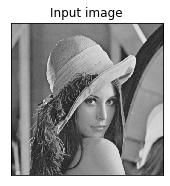

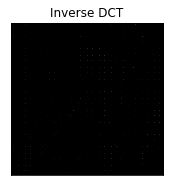

In [13]:
e_img, e_DCT, e_original_shape = dct('lena512.pgm')

plt.subplot(121),plt.imshow(e_img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(e_DCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

### Passo 2: ZigZag
A matriz é vetorizada seguindo o ZigZag

In [14]:
e_vector = ZigZag(e_DCT)

print(e_vector)

[16, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, -2, 1, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, -2, 0, 0, 0, -1, 0, 0, 0, 0

### Passo 3: Aplicação da Função de Predição
Esse passo busca aumentar a concentração de valores da matriz em torno de -1, 0 e 1, diminuindo assim a entropia da imagem.

In [15]:
e_predictive = LosslessPredictive(e_vector)

print(CalcEntropyDictionary(CalcHist(e_vector)))
print(CalcEntropyDictionary(CalcHist(e_predictive)))

0.9309132787335425
1.2165433347544987


### Passo 4: É encontrado o mapeamento dos valores para binário usando codificação de Huffman

In [16]:
e_codes = HuffmanEncoding(e_predictive)

print(e_codes)

{0: '0', -6: '10000000', -10: '100000010', -39: '1000000110', 28: '10000001110', 43: '10000001111', 6: '10000010', 13: '100000110', 15: '100000111', 4: '1000010', -40: '1000011000', -22: '1000011001', 14: '100001101', -11: '100001110', -20: '1000011110', -19: '1000011111', -18: '1000100000', 25: '1000100001', -23: '1000100010', -49: '10001000110000', 57: '1000100011000100', -68: '1000100011000101', 49: '100010001100011', -44: '1000100011001', -52: '100010001101000', -51: '100010001101001', 48: '10001000110101', -45: '1000100011011', -42: '10001000111', 39: '1000100100', -24: '1000100101', 38: '1000100110', 19: '1000100111', -4: '1000101', -15: '100011000', 32: '10001100100', 29: '10001100101', -38: '1000110011', 26: '1000110100', -34: '1000110101', 40: '1000110110', 24: '1000110111', -7: '10001110', 7: '10001111', 2: '10010', 3: '100110', -25: '1001110000', -37: '1001110001', 21: '1001110010', -36: '1001110011', 8: '10011101', 16: '100111100', 37: '1001111010', -41: '1001111011', 30: '

### Passo 5: Após encontrar o mapeamento, os dados são comprimidos pela primeira vez

In [17]:
e_encoded_bin_string = EncodeData(e_predictive, e_codes)
print(e_encoded_bin_string)

1001111001011011011101110000000000000000000000000000000000000000000000000000000000001001111001011110111111100000000000000000000000000000000000000000000000000000000000010000110110111100011100111110000000000000000000000000000000000000000000000000000000001000001101011110000011011100000000000000000000000000000000000000000000000000000000010000011110110111010011011101101111111100000000000000000000000000000000000000000000000000000000100111001010001000101001000111110000000000000000000000000000000000000000000000000000000000101100010110110111010101000111110000000000000000000000000000000000000000000000000000000000100101011000010000001011101111101111100000111011000000000000000000000000000000000000000000000000010110111010111110011010100110100101010000000000000000000000000000000000000000000000000000000000010111000101110101001101111101110000000000000000000000000000000000000000000000000000000000100001110101110111101110110111000000000000000000000000000000000000000000000000000000000100001110101110101001

### Passo 6: Os dados codificados são convertidos em uma string no alfabeto ascii e o tamanho da string é armazenado para facilitar na descompressão

In [18]:
e_encoded_char_string = bin2string(e_encoded_bin_string)
e_first_encode_size = len(e_encoded_char_string)
print(e_encoded_char_string)

¼çÀ      ¾ÅÙM»p     ÄnGÀ      ÉyAh)°ø     wåUzR]åL      ³
À       Ü       à               >       Ù÷ÔÇÇÀÜ    à       ª       e0       ZÇÍé
qÀ      ¼       n¥ø³U      ®rþÌ(	K      óÜ]
Ì¼¸      ï%üuÝ¬ì¤ÜÜ     Spn      °·n       ª`       *       
À      ð       7       p       56¦       7       R\       %ÿp     Ë      Ü       ;       à       >        oð      }À      T       ¸       ð      á¸      à       ð      ¨ì       ³;SS>      wL              ¸Å~       Ët¸       O#       Ëh       {Þ       mè       kfà      5Å0       _Ã¸       .¡ÒU
©S     c\åò:½dÒà      -.ç>Ôß       ßÃÚd¬±ñ¸     ++ÂàÜ      fÜ|      
À      =å
÷Ü       Ü|n              qð      .|       ª7       Scp      &pø      
À      n       Bp       }À      [º       Ê¹¸      
Y<¬+)ð     z~ªò©hªý¸Ü     ÄmÇn      !Í÷       N3Ñ÷À      I¨       ÄÿTÜÎ      ÷?À      Øy-À      íí)Ø      4|X
à      rï      òï      kî       M¸      

### Passo 7: Os passos 4, 5 e 6 são repetidos, comprimindo ainda mais a string codificada

In [19]:
e_codes_2 = HuffmanEncoding(e_encoded_char_string)
e_encoded_bin_string_2 = EncodeData(e_encoded_char_string, e_codes_2)
e_encoded_char_string_2 = bin2string(e_encoded_bin_string_2)

print('Tamanho após primeira codificação (em bytes): {}'.format(len(e_encoded_char_string)))
print('Tamanho após segunda codificação (em bytes): {}'.format(len(e_encoded_char_string_2)))

Tamanho após primeira codificação (em bytes): 53414
Tamanho após segunda codificação (em bytes): 36180


### Passo 8: Os dois mapeamentos, tamanho da imagem, tamanho da primeira transformação para ascii e os dados em si são guardados em um dicionário, o qual é armazenado no disco, chegando assim no tamanho final da compressão

In [20]:
e_core_values = dict()
e_core_values['Data'] = e_encoded_char_string_2
e_core_values['First Encoding Codes'] = CompressDict(e_codes)
e_core_values['First Encode Size'] = e_first_encode_size
e_core_values['Second Encoding Codes'] = CompressDict(e_codes_2)
e_core_values['Original Shape'] = e_original_shape

with open('comprimindo_passo_a_passo.pickle', 'wb') as file:
    pickle.dump(e_core_values, file)
    
print('Tamanho do arquivo comprimido: ', os.path.getsize('comprimindo_passo_a_passo.pickle'))
print('Tamanho da imagem: ', e_img.size)
print('Taxa de compressão: %5.3f' % (os.path.getsize('comprimindo_passo_a_passo.pickle')/e_img.size))

Tamanho do arquivo comprimido:  57299
Tamanho da imagem:  262144
Taxa de compressão: 0.219


### Passo 9: Abertura do Arquivo e Carregamento das Variáveis
Os dicionárioes de codificações estão codificados, de forma a ocuparem menos memória, portanto, no momento que são lidos, a decodificações destes é feita ao mesmo tempo.

In [21]:
with open('comprimindo_passo_a_passo.pickle', 'rb') as file:
    d_core_values = pickle.load(file)
    
d_encoded_char_string_2 = d_core_values['Data']
d_codes = DecompressDict(d_core_values['First Encoding Codes'])
d_first_encode_size = d_core_values['First Encode Size']
d_codes_2 = DecompressDict(d_core_values['Second Encoding Codes'])
d_original_shape = d_core_values['Original Shape']

print(d_core_values['First Encoding Codes'])
print(d_codes)

{0: (1, 0), -6: (8, 128), -10: (9, 258), -39: (10, 518), 28: (11, 1038), 43: (11, 1039), 6: (8, 130), 13: (9, 262), 15: (9, 263), 4: (7, 66), -40: (10, 536), -22: (10, 537), 14: (9, 269), -11: (9, 270), -20: (10, 542), -19: (10, 543), -18: (10, 544), 25: (10, 545), -23: (10, 546), -49: (14, 8752), 57: (16, 35012), -68: (16, 35013), 49: (15, 17507), -44: (13, 4377), -52: (15, 17512), -51: (15, 17513), 48: (14, 8757), -45: (13, 4379), -42: (11, 1095), 39: (10, 548), -24: (10, 549), 38: (10, 550), 19: (10, 551), -4: (7, 69), -15: (9, 280), 32: (11, 1124), 29: (11, 1125), -38: (10, 563), 26: (10, 564), -34: (10, 565), 40: (10, 566), 24: (10, 567), -7: (8, 142), 7: (8, 143), 2: (5, 18), 3: (6, 38), -25: (10, 624), -37: (10, 625), 21: (10, 626), -36: (10, 627), 8: (8, 157), 16: (9, 316), 37: (10, 634), -41: (10, 635), 30: (11, 1272), 45: (12, 2546), -48: (14, 10188), 65: (16, 40756), 56: (16, 40757), 54: (16, 40758), 53: (16, 40759), -64: (16, 40760), 50: (16, 40761), -57: (16, 40762), -54: 

### Passo 10: Como as dimensões da matriz DCT podem ser diferentes das dimensões da matriz original, as dimensões dessa precisam ser recalculadas

In [22]:
d_dct_shape = (d_original_shape[0] + (8 - (d_original_shape[0]%8))%8, d_original_shape[1] + (8 - (d_original_shape[1]%8))%8)

### Passo 11: A segunda compressão de Huffman é desfeita
Observe que no dicionário de decodificação, a função ReverseEncode inverte imagem e domínio do mapeamento.

In [23]:
d_decoding_values_2 = ReverseEncode(d_codes_2)
d_decoded_bin_string_2 = string2bin(d_encoded_char_string_2)
d_decoded_char_list_2 = DecodeData(d_decoded_bin_string_2, d_decoding_values_2, d_first_encode_size)
d_decoded_char_string_2 = ''.join(d_decoded_char_list_2)

print(d_decoded_char_string_2 == e_encoded_char_string)
print(d_decoding_values_2)
print(d_decoded_char_string_2)

True
{'00000000000': '\x0e', '00000000001': '\x84', '0000000001': 'ù', '0000000010': 'c', '0000000011': 'Ö', '0000000100': 'ã', '0000000101': 'x', '000000011': '*', '0000001000': '÷', '0000001001': '²', '0000001010': '\x96', '0000001011': 'Ã', '0000001100': 'ý', '0000001101': '´', '0000001110': 'C', '0000001111': '\x82', '000001000': '\x03', '0000010010': 'ô', '0000010011': 'u', '000001010': 'j', '000001011': '\r', '0000011000': 'l', '0000011001': 'Ý', '000001101': '}', '0000011100': '\x18', '0000011101': 'Ì', '0000011110': ':', '0000011111': 'Q', '00001000': '\x04', '0000100100': '&', '0000100101': 'a', '000010011': '\x15', '0000101': '\x01', '0000110000': 's', '0000110001': 'Ä', '000011001': '`', '000011010': '\x0f', '000011011': '¾', '00001110': 'p', '000011110': '·', '0000111110': '\x88', '0000111111': '¢', '00010000': '¸', '000100010': '.', '000100011': 'T', '0001001': '\x80', '000101000': '5', '000101001': '\x16', '000101010': '-', '0001010110': '\x81', '0001010111': 'Â', '000101

### Passo 12: A primeira compressão de Huffman é desfeita
É importante observar que a comparação entre a string binária original e a descomprimida pode dar falso, uma vez, durante o processamento da original, podem ter sido adicionados zeros ao final desta, para que pudesse ser covertida em um string de caracteres.

In [24]:
d_decoding_values = ReverseEncode(d_codes)
d_decoded_bin_string = string2bin(d_decoded_char_string_2)
d_decoded_data = DecodeData(d_decoded_bin_string, d_decoding_values, d_dct_shape[0]*d_dct_shape[1])

print(d_decoded_bin_string == e_encoded_bin_string)
print(d_decoded_data == e_predictive)

True
True


### Passo 13: Desfazer a preditiva

In [25]:
d_after_prediction = UndoLosslessPredictive(d_decoded_data)

print(d_after_prediction == e_vector)

True


### Passo 14: Desfazer o ZigZag

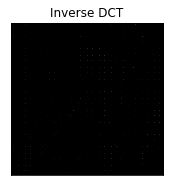

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [26]:
d_DCT = UndoZigZag(d_after_prediction, d_dct_shape)

plt.subplot(121),plt.imshow(d_DCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

print(d_DCT == e_DCT)

### Passo 15: Por fim, é aplicada a DCT inversa

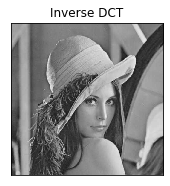

RMSE: 4.133
PSNR: 35.805


In [27]:
d_IDCT = idct(d_DCT, d_original_shape)

plt.subplot(121),plt.imshow(d_IDCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

print("RMSE: %5.3f" % RMSE(e_img, d_IDCT))
print("PSNR: %5.3f" % PSNR(e_img, d_IDCT))